In [1]:
import sys
sys.path.append('../')
import torch
import dill
import os.path as op
import numpy as np
import hnn_core
from hnn_core import simulate_dipole, Network, read_params, JoblibBackend
import matplotlib as mpl
import matplotlib.pyplot as plt
import sbi.utils as utils
from sbi.inference.base import infer
import multiprocessing
import datetime
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from scipy import interpolate
import glob
import pandas as pd
import spike_train_functions
import hnn_simnets_functions
import numba
import sbi_functions
from sbi_functions import run_simulator
from joblib import Parallel, delayed
import umap
import umap.plot


/home/ntolley/anaconda3/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)
/home/ntolley/anaconda3/lib/python3.7/site-packages/holoviews/operation/datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


In [2]:
save_name = 'beta_event_t10000_01152021_161512'
data_path = '/home/ntolley/Jones_Lab/sbi_hnn/data/beta/prerun_simulations/' + save_name + '/'

prior_dict_file = open(data_path + 'prior_dict_' + save_name + '.pkl', 'rb')
prior_dict = dill.load(prior_dict_file)
prior_dict_file.close()

prior_file = open(data_path + 'prior_' + save_name + '.pkl', 'rb')
prior = dill.load(prior_file)
prior_file.close()

# params_fname_file = open(data_path + 'params_fname_' + save_name + '.pkl', 'rb')
# params_fname = dill.load(params_fname_file)
# params_fname_file.close()
params_fname = '../../data/beta/params/beta_param.param'

dpl_files = sorted(glob.glob(data_path + 'data/*dpl*sim*'))
theta_files = sorted(glob.glob(data_path + 'data/*theta*sim*'))
# spike_gids_files = sorted(glob.glob(data_path + 'data/spike_gids*'))
# spike_times_files = sorted(glob.glob(data_path + 'data/spike_times*'))
# spike_types_files = sorted(glob.glob(data_path + 'data/spike_types*'))

In [3]:
#_____testing____
# file_idx = 0
# dpl = np.loadtxt(dpl_files[file_idx],delimiter=',')
# theta = np.loadtxt(theta_files[file_idx],delimiter=',')
#____________

# dpl = np.vstack([np.loadtxt(dpl_files[file_idx],delimiter=',') for file_idx in range(len(dpl_files))])
# theta = np.vstack([np.loadtxt(theta_files[file_idx],delimiter=',') for file_idx in range(len(theta_files))])

beta23 = np.loadtxt('../../data/beta/aging_grant/S1_23.txt')
beta43 = np.loadtxt('../../data/beta/aging_grant/S10_43.txt')
#convert to ms
beta23[:,0] = beta23[:,0] * 1e3
beta43[:,0] = beta43[:,0] * 1e3

#Interpolate to match simulation timepoints
num_pts = 10001
new_x = np.linspace(0,500,num_pts)

beta23_interp_func = interpolate.interp1d(beta23[:,0], beta23[:,1], kind='cubic')
beta23_dpl = beta23_interp_func(new_x)

beta43_interp_func = interpolate.interp1d(beta43[:,0], beta43[:,1], kind='cubic')
beta43_dpl = beta43_interp_func(new_x)

#Apply dipole scaling
scaling = 1e2
beta23_dpl, beta43_dpl = beta23_dpl*scaling, beta43_dpl*scaling





In [6]:
inference = SNPE(prior=prior)
inference = inference.append_simulations(torch.as_tensor(theta).float(), torch.as_tensor(dpl).float())
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

/home/ntolley/anaconda3/lib/python3.7/site-packages/nflows/transforms/standard.py:76: DeprecationWarning: Use PointwiseAffineTransform
  warnings.warn("Use PointwiseAffineTransform", DeprecationWarning)
Neural network successfully converged after 98 epochs.


In [4]:
#___Save posterior___
# save_file = open(data_path + 'posterior.pkl', 'wb')
# dill.dump(posterior, save_file)
# save_file.close()

#___Load posterior___
posterior_file = open(data_path + 'posterior.pkl', 'rb')
posterior = dill.load(posterior_file)
posterior_file.close()

In [5]:
num_samples = 8
theta_samples_beta23 = posterior.sample((num_samples,), x=beta23_dpl)
theta_samples_beta43 = posterior.sample((num_samples,), x=beta43_dpl)

In [6]:
res_beta23 = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_beta23[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))
res_beta43 = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_beta43[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))


Text(0.5, 1.0, 'Inferred Beta')

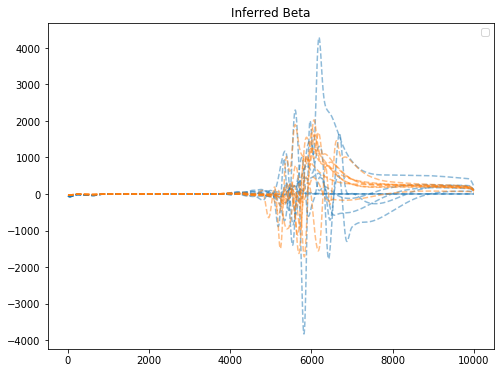

In [9]:
plt.figure(figsize=(8,6))
# plt.plot(beta23_dpl, 'C0', LineWidth=3)
# plt.plot(beta43_dpl, 'C1',LineWidth=3)
plt.legend(['beta23', 'beta43'])
for sim_idx in range(len(res_beta23)):
    plt.plot(res_beta23[sim_idx][0], 'C0', LineStyle='--', alpha=0.5)
for sim_idx in range(len(res_beta43)):
    plt.plot(res_beta43[sim_idx][0], 'C1', LineStyle='--', alpha=0.5)

plt.title('Inferred Beta')


In [31]:
samples = posterior.sample((100000,), x=beta23_dpl)
#log_probability = posterior.log_prob(samples, x=observation)
_ = utils.pairplot(samples, fig_size=(20,20))